(mixing_line_calc_solution)=
# Mixing line workbook

In the first part of the the term we calculated the temperature of a cloud-environment mixture using
a tephigram.  In this notebook we calculate the virtural temperature of 100 different
mixtures using the thermlim functions

In [1]:
import numpy as np
import pandas as pd
from pprint import pformat
import numpy as np
import json

from a405.thermo.constants import constants as c

In [2]:
from a405.soundings.wyominglib import write_soundings, read_soundings
from a405.thermo.thermlib import (find_Tmoist,find_rsat,find_Tv,find_lcl,find_thetaet,
                                  tinvert_thetae)
from matplotlib import pyplot as plt

## Get a little rock sounding

set get_data=True the first time through, then False for subsequent runs with the stored sounding in save_sounding.csv and metada.json

In [3]:
get_data=False
if get_data:
    values=dict(region='naconf',year='2012',month='7',start='0100',stop='3000',station='72340')
    write_soundings(values, 'littlerock')
    soundings= read_soundings('littlerock')
    the_time=(2012,7,17,0)
    sounding=soundings['sounding_dict'][the_time]
    title_string=soundings['attributes']['header']
    index=title_string.find(' Observations at')
    location=title_string[:index]
    print(f'location: {location}')
else:
    soundings= read_soundings('littlerock')
all_sounds = soundings['sounding_dict']
all_keys = list(all_sounds.keys())
    
    

In [4]:
# all_keys

In [5]:
np.seterr(all='ignore');

In [6]:
the_sound = all_sounds[(2012,7,27,0)]

# find the $\theta_{e}$ of the  LCL

## convert surface values to mks

In [7]:
#
# find thetae of the surface air, at index 0
#
sfc_press,sfc_temp,sfc_td =[the_sound[key][0] for key in ['pres','temp','dwpt']]
#
sfc_press,sfc_temp,sfc_td = sfc_press*100.,sfc_temp+c.Tc,sfc_td+c.Tc
sfc_press, sfc_temp,sfc_td

(98800.0, 309.95, 291.95)

## What is the LCL of this air?

In [8]:
Tlcl, plcl=find_lcl(sfc_td, sfc_temp,sfc_press)

In [9]:
print(f'found Tlcl={Tlcl:.2f} K, plcl={plcl*1.e-2:.2f} hPa')

found Tlcl=287.87 K, plcl=761.92 hPa


## find sfc rv values and check that they match lcl

In [10]:
sfc_rvap = find_rsat(sfc_td,sfc_press)
lcl_rvap = find_rsat(Tlcl,plcl)
sfc_rvap, lcl_rvap

(0.013959777747524393, 0.013967928461792234)

## Find surface $\theta_e$

In [11]:
sfc_thetae=find_thetaet(sfc_td,sfc_rvap,sfc_temp,sfc_press)
sfc_thetae

351.24772810478737

In [12]:
#
# find the index for 700 Pa/7 hPa pressure -- searchsorted requires
# the pressure array to be increasing, so flip it for the search,
# then flip the index.  Above 100 hPa thetae goes bananas, so
# so trim so we only have good values
#
press = the_sound['pres']*100.
toplim=len(press) - np.searchsorted(press[::-1],.7e4)
clipped_press=press[:toplim]
#
# find temps along that adiabat
#
adia_temps= np.array([find_Tmoist(sfc_thetae,the_press) 
                      for the_press in clipped_press])
#
# find the liquid water content for the adiabat by subtracting
# the vapor mixing ratio from the sfc mixing ratio
#
adia_rvaps = find_rsat(adia_temps,clipped_press)
adia_rls = sfc_rvap - adia_rvaps
env_temps = (the_sound['temp'].values + c.Tc)[:toplim]
env_Td = (the_sound['dwpt'].values + c.Tc)[:toplim]
height = the_sound['hght'].values[:toplim]
pairs = zip(env_Td,clipped_press)
env_rvaps= np.array([find_rsat(td,the_press) for td,the_press in pairs])
env_Tv = find_Tv(env_temps,env_rvaps)
adia_Tv = find_Tv(adia_temps,adia_rvaps,adia_rls)
press_hPa = clipped_press*1.e-2

## find the density of 100 mixtures of cloud and environment at 600 hPa

## find the environmental rv and $\theta_e$ at 600 hPa

In [13]:
mix_level=np.searchsorted(clipped_press[::-1],600.e2)
index=len(clipped_press) - mix_level
mix_press_600, env_Td_600, env_temp_600 = clipped_press[index],env_Td[index],env_temps[index]
print(f"pressure, {mix_press_600*1.e-2:.1f} hPa  dewpoint {env_Td_600:.1f} K , temp {env_temp_600:.1f} K")
env_rvap = env_rvaps[index]
env_thetae = find_thetaet(env_Td_600,env_rvap,env_temp_600,mix_press_600)

pressure, 597.0 hPa  dewpoint 264.8 K , temp 275.8 K


## Make 100 mixtures

In the cell below, construct a list of 100 pairs of ($\theta_e$, $r_T$) for 100 mixtures of
cloud and environmental air at 600 hPa

Find the virtual temperature for each mixture, and make a plot of fraction of environmental air vs virtual temperature

In [14]:
print(f'cloud thetae {sfc_thetae:5.3f} K, env_thetae {env_thetae:5.3f} K')
print(f'cloud rt {sfc_rvap:5.3f} g/kg, env rt {env_rvap:5.3f} g/kg')
fenv=np.linspace(0,1,100)
#
# make 100 mixtures
#
logthetae_mix = fenv*np.log(env_thetae) + (1 - fenv)*np.log(sfc_thetae)
rTot_mix = fenv*env_rvap  + (1 - fenv)*sfc_rvap
thetae_mix = np.exp(logthetae_mix)
pairs = zip(thetae_mix,rTot_mix)

cloud thetae 351.248 K, env_thetae 329.579 K
cloud rt 0.014 g/kg, env rt 0.003 g/kg


## Find Tv for each mixture

Create a list called Tvlist that holds Tv for each mixture

In [15]:
#
# find the virtual temperature for each mixture and append
# to a list called Tvlist
#
Tvlist = []
for thetae,rtot in pairs:
    temp,rv,rl = tinvert_thetae(thetae,rtot,mix_press_600)
    Tvlist.append(find_Tv(temp,rv,rl))

## Make a plot of fenv vs. Tv

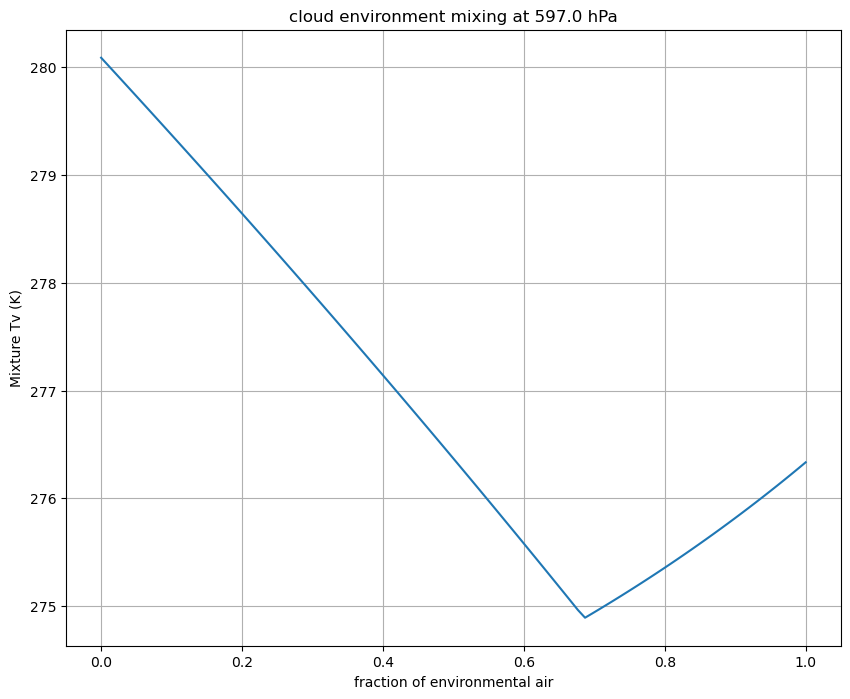

In [18]:
fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(fenv,Tvlist)
title=f'cloud environment mixing at {mix_press_600*1.e-2:.1f} hPa'
out=ax.set(xlabel='fraction of environmental air',ylabel='Mixture Tv (K)',title=title)
ax.grid(True,which='both')